<a href="https://colab.research.google.com/github/Haebuk/kuggle/blob/main/Apr_Kaggle_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2021 Apr Modeling
- [
N3. [TPS April 21] LightAutoML starter](https://www.kaggle.com/alexryzhkov/n3-tps-april-21-lightautoml-starter)
- [
TPS Apr 2021 pseudo labeling/voting ensemble](https://www.kaggle.com/hiro5299834/tps-apr-2021-pseudo-labeling-voting-ensemble/notebook?select=pseudo_label.csv )
- [Pseudolabelling - Tips and tricks](https://www.kaggle.com/c/tabular-playground-series-apr-2021/discussion/231738)


## Colab Softwrap

In [1]:
# colab softwrap
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Libraries

In [2]:
import pandas as pd
import numpy as np
import random
import time
import os

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import torch
from sklearn.linear_model import LogisticRegression as lr
!pip install -q lightgbm==3.2.1
import lightgbm as lgb
!pip install -q catboost
import catboost as ctb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')


     |████████████████████████████████| 2.0MB 8.9MB/s 
     |████████████████████████████████| 67.3MB 52kB/s 


In [56]:
TARGET = 'Survived'

N_THREADS = 4
N_FOLDS = 10
TEST_SIZE = 0.2
TIMEOUT = 3 * 3600
N_ESTIMATORS = 1000
N_SPLITS = 10
SEED = 2021
EARLY_STOPPING_ROUNDS = 100 
VERBOSE = 100

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHEED'] = str(seed)
    np.random.seed(seed)

set_seed(SEED)

torch.set_num_threads(N_THREADS)

## Git Clone & Load Data

In [5]:
!git clone https://github.com/Haebuk/kuggle.git
PATH = '/content/kuggle/9,10주차/input/'
train_df = pd.read_csv(PATH+'train.csv')
test_df = pd.read_csv(PATH+'test.csv')
submission_df = pd.read_csv(PATH+'sample_submission.csv')

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

Cloning into 'kuggle'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 56 (delta 10), reused 44 (delta 7), pack-reused 0
Unpacking objects: 100% (56/56), done.


## Filling Missing Values

In [6]:
all_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
199995,199995,NaN,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q
199996,199996,NaN,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S
199997,199997,NaN,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S
199998,199998,NaN,1,"Jacobsen, Margaret",female,49.0,1,2,PC 26988,29.68,B20828,C
199999,199999,NaN,1,"Fishback, Joanna",female,41.0,0,2,PC 41824,195.41,E13345,C


In [7]:
for col in all_df.columns:
    print(col, all_df[col].isnull().sum())

PassengerId 0
Survived 100000
Pclass 0
Name 0
Sex 0
Age 6779
SibSp 0
Parch 0
Ticket 9804
Fare 267
Cabin 138697
Embarked 527


In [51]:
def fill_nan_values(data):
    # 연령 결측값 -> 평균으로 대체
    data['Age'] = data['Age'].fillna(data['Age'].mean())
    # 선실 결측값 -> X로 대체 및 나머지는 첫글자로 대체
    data['Cabin'] = data['Cabin'].fillna('X').map(lambda x: x[0].strip())

    # 티켓 결측값 -> X로 대체 및 나머지는 첫 어절로 대체
    data['Ticket'] = data['Ticket'].fillna('X').\
    map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

    # 요금 결측값 -> Pclass의 중위수로 대체 후 로그변환(정규화)
    fare_map = data[['Fare', 'Pclass']].dropna().groupby('Pclass').median().to_dict()
    data['Fare'] = data['Fare'].fillna(data['Pclass'].map(fare_map['Fare']))
    data['Fare'] = np.log1p(data['Fare'])

    # 탑승항구 결측값 -> X로 대체
    data['Embarked'] = data['Embarked'].fillna('X')

    # 성을 제외한 이름만 추출
    data['Name'] = data['Name'].map(lambda x: x.split(',')[0])
    
    return data

In [ ]:
all_df = fill_nan_values(all_df)

## Encoding

In [9]:
label_cols = ['Name', 'Ticket', 'Sex']
onehot_cols = ['Cabin', 'Embarked']
numerical_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [10]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

scaler = StandardScaler()

onehot_encoded_df = pd.get_dummies(all_df[onehot_cols])
label_encoded_df = all_df[label_cols].apply(label_encoder)
numerical_df = pd.DataFrame(scaler.fit_transform(all_df[numerical_cols]), 
                            columns=numerical_cols)
target_df = all_df[TARGET]

all_df = pd.concat([numerical_df, label_encoded_df, onehot_encoded_df, target_df],\
                   axis=1)

In [11]:
train_df2 = all_df[:train_df.shape[0]]
test_df2 = all_df[train_df.shape[0]:]

## Logistic Regression


In [12]:
feature_importances = pd.DataFrame()
X_test = test_df2.drop(TARGET, axis=1)
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df2, train_df2[TARGET])):
    print(f'===== FOLD {fold} =====')

    X_train, y_train = train_df2.iloc[train_idx].drop(TARGET, axis=1),\
    train_df.iloc[train_idx][TARGET]
    X_valid, y_valid = train_df2.iloc[valid_idx].drop(TARGET, axis=1),\
    train_df.iloc[valid_idx][TARGET]

    model = lr(max_iter=300, verbose=VERBOSE)
    model.fit(X_train, y_train)
    
    lr_val = model.predict(X_valid)
    lr_val = [1 if v >= 0.5 else 0 for v in lr_val]
    lr_preds = model.predict(X_test)

    
    # 확률이 0.5보다 크면 1, 작으면 0으로 분류
    acc_score = accuracy_score(y_valid, lr_val)
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")

===== FOLD 0 =====
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
===== ACCURACY SCORE 0.761900 =====

===== FOLD 1 =====
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
===== ACCURACY SCORE 0.773500 =====

===== FOLD 2 =====
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
===== ACCURACY SCORE 0.769900 =====

===== FOLD 3 =====
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of  

In [32]:
submission_df_lr = pd.read_csv(PATH+'sample_submission.csv')
submission_df_lr['Survived'] = lr_preds
submission_df_lr.to_csv('lr_model.csv', index=False) # 0.78550 score

## LightGBM

In [59]:
params_lgb = {
    'metric': 'binary_logloss',
    'n_estimators': N_ESTIMATORS,
    'objective': 'binary',
    'random_state': SEED,
    'learning_rate': 0.01,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
}

In [14]:
feature_importances = pd.DataFrame()
X_test = test_df2.drop(TARGET, axis=1)
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df2, train_df2[TARGET])):
    print(f'===== FOLD {fold} =====')

    X_train, y_train = train_df2.iloc[train_idx].drop(TARGET, axis=1),\
    train_df.iloc[train_idx][TARGET]
    X_valid, y_valid = train_df2.iloc[valid_idx].drop(TARGET, axis=1),\
    train_df.iloc[valid_idx][TARGET]

    pre_model = lgb.LGBMRegressor(**params_lgb)
    pre_model.fit(
        X_train, y_train,
        eval_set = [(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds = EARLY_STOPPING_ROUNDS,
        verbose = VERBOSE
    )

    params_lgb2 = params_lgb.copy()
    params_lgb2['learning_rate'] = params_lgb['learning_rate'] * 0.1
    model = lgb.LGBMRegressor(**params_lgb2)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train),(X_valid, y_valid)],
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE,
        init_model=pre_model
    )

    # feature importance
    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = model.feature_name_
    fi_tmp['importance'] = model.feature_importances_
    fi_tmp['fold'] = fold
    fi_tmp['seed'] = SEED
    feature_importances = feature_importances.append(fi_tmp)
    
    lgb_val = model.predict(X_valid)
    lgb_val = [1 if v >= 0.5 else 0 for v in lgb_val]
    lgb_preds = model.predict(X_test)

    
    # 확률이 0.5보다 크면 1, 작으면 0으로 분류
    acc_score = accuracy_score(y_valid, lgb_val)
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")

===== FOLD 0 =====
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.52195	valid_1's binary_logloss: 0.523998
[200]	training's binary_logloss: 0.484826	valid_1's binary_logloss: 0.488637
[300]	training's binary_logloss: 0.473859	valid_1's binary_logloss: 0.479154
[400]	training's binary_logloss: 0.469461	valid_1's binary_logloss: 0.475771
[500]	training's binary_logloss: 0.467025	valid_1's binary_logloss: 0.474104
[600]	training's binary_logloss: 0.465386	valid_1's binary_logloss: 0.473314
[700]	training's binary_logloss: 0.464096	valid_1's binary_logloss: 0.472792
[800]	training's binary_logloss: 0.463023	valid_1's binary_logloss: 0.472523
[900]	training's binary_logloss: 0.462084	valid_1's binary_logloss: 0.47237
[1000]	training's binary_logloss: 0.461183	valid_1's binary_logloss: 0.472227
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.461183	valid_1's binary_logloss: 0.472227
Training until validatio

### Feature Importance

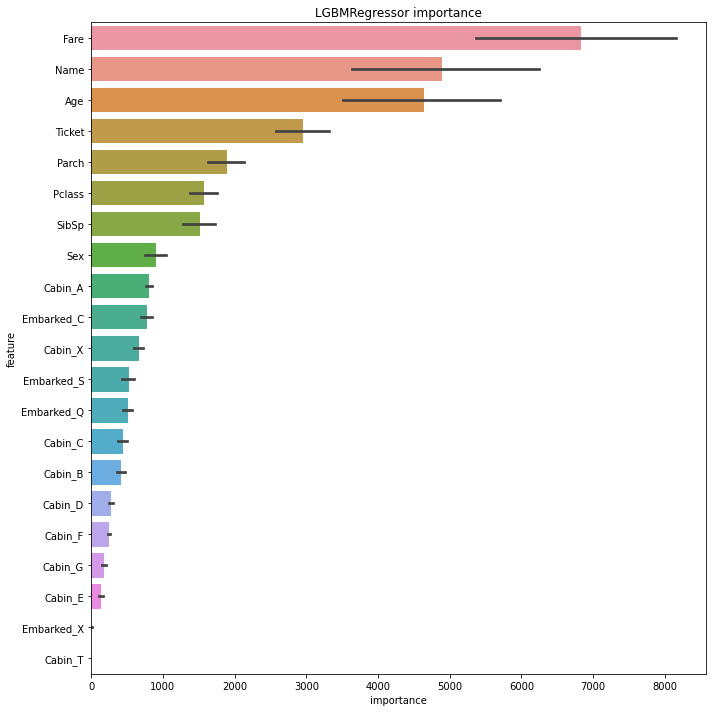

In [15]:
order = list(feature_importances.groupby('feature').mean().\
             sort_values('importance', ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importances, order=order)
plt.title('{} importance'.format('LGBMRegressor'))
plt.tight_layout()

## CatBoost

In [16]:
params = {
    'bootstrap_type': 'Poisson',
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_seed': SEED,
    'task_type': 'GPU',
    'max_depth': 8,
    'learning_rate': 0.01,
    'n_estimators': N_ESTIMATORS,
    'max_bin': 280,
    'min_data_in_leaf': 64,
    'l2_leaf_reg': 0.01,
    'subsample': 0.8
}

In [17]:
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df2, train_df2[TARGET])):
    print(f'===== FOLD {fold} =====')

    X_train, y_train = train_df2.iloc[train_idx].drop(TARGET, axis=1),\
    train_df.iloc[train_idx][TARGET]
    X_valid, y_valid = train_df2.iloc[valid_idx].drop(TARGET, axis=1),\
    train_df.iloc[valid_idx][TARGET]

    model = ctb.CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        use_best_model = True,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE,
    )

    # feature importance
    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = X_test.columns.to_list()
    fi_tmp['importance'] = model.get_feature_importance()
    fi_tmp['fold'] = fold
    fi_tmp['seed'] = SEED
    feature_importances = feature_importances.append(fi_tmp)
    
    ctb_val = model.predict(X_valid)
    ctb_val = [1 if v >= 0.5 else 0 for v in ctb_val]
    ctb_preds = model.predict(X_test)
    
    # 확률이 0.5보다 크면 1, 작으면 0으로 분류
    acc_score = accuracy_score(y_valid, ctb_val)
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")

===== FOLD 0 =====
0:	learn: 0.6880902	test: 0.6881691	best: 0.6881691 (0)	total: 21.3ms	remaining: 21.3s
100:	learn: 0.4980871	test: 0.5026102	best: 0.5026102 (100)	total: 2s	remaining: 17.8s
200:	learn: 0.4738237	test: 0.4815462	best: 0.4815462 (200)	total: 3.89s	remaining: 15.5s
300:	learn: 0.4671814	test: 0.4774666	best: 0.4774666 (300)	total: 5.79s	remaining: 13.5s
400:	learn: 0.4634908	test: 0.4758771	best: 0.4758771 (400)	total: 7.65s	remaining: 11.4s
500:	learn: 0.4606593	test: 0.4750852	best: 0.4750852 (500)	total: 9.46s	remaining: 9.43s
600:	learn: 0.4581859	test: 0.4746116	best: 0.4746116 (600)	total: 11.3s	remaining: 7.5s
700:	learn: 0.4559720	test: 0.4743882	best: 0.4743882 (700)	total: 13.1s	remaining: 5.6s
800:	learn: 0.4538508	test: 0.4742176	best: 0.4742176 (800)	total: 14.9s	remaining: 3.7s
900:	learn: 0.4517629	test: 0.4742169	best: 0.4741876 (830)	total: 16.8s	remaining: 1.84s
999:	learn: 0.4498074	test: 0.4742145	best: 0.4741178 (985)	total: 18.6s	remaining: 0us
be

### Feature Importance

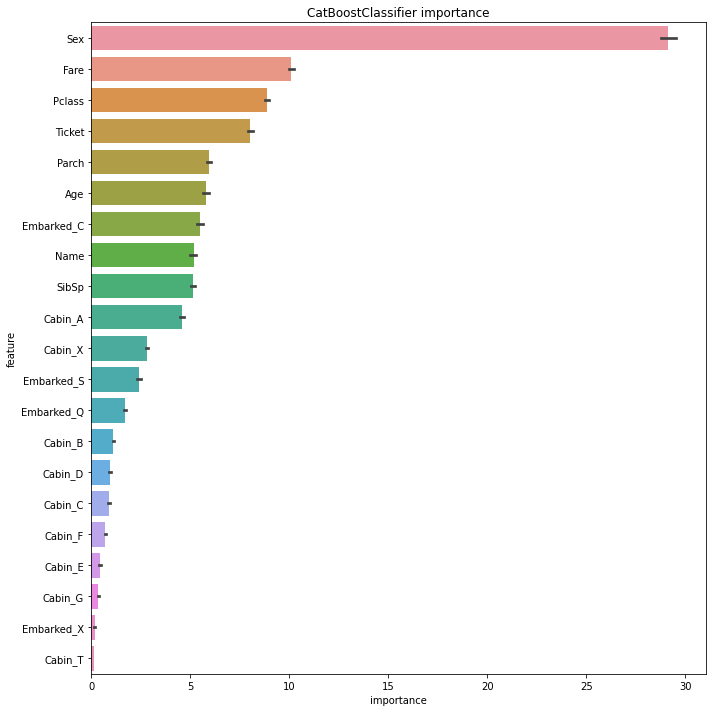

In [18]:
order = list(feature_importances.groupby("feature").mean()\
             .sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("CatBoostClassifier"))
plt.tight_layout()

## DecisionTreeModel

In [19]:
parameters = {
    'max_depth': np.arange(2, 5, dtype=int),
    'min_samples_leaf': np.arange(2, 5, dtype=int)
}

classifier = DecisionTreeClassifier(random_state=2021)

model = GridSearchCV(
    estimator = classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)
model.fit(X_train, y_train)

best_parameters = model.best_params_
print(best_parameters)

{'max_depth': 4, 'min_samples_leaf': 2}


In [20]:
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df2, train_df2[TARGET])):
    print(f'===== FOLD {fold} =====')

    X_train, y_train = train_df2.iloc[train_idx].drop(TARGET, axis=1),\
    train_df.iloc[train_idx][TARGET]
    X_valid, y_valid = train_df2.iloc[valid_idx].drop(TARGET, axis=1),\
    train_df.iloc[valid_idx][TARGET]

    model = DecisionTreeClassifier(
        max_depth = best_parameters['max_depth'],
        min_samples_leaf = best_parameters['min_samples_leaf'],
        random_state = SEED
    )
    model.fit(X_train, y_train)
    
    dtm_val = model.predict(X_valid)
    dtm_val = [1 if v >= 0.5 else 0 for v in dtm_val]
    dtm_preds = model.predict(X_test)

    
    # 확률이 0.5보다 크면 1, 작으면 0으로 분류
    acc_score = accuracy_score(y_valid, dtm_val)
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")

===== FOLD 0 =====
===== ACCURACY SCORE 0.766600 =====

===== FOLD 1 =====
===== ACCURACY SCORE 0.783400 =====

===== FOLD 2 =====
===== ACCURACY SCORE 0.771000 =====

===== FOLD 3 =====
===== ACCURACY SCORE 0.770500 =====

===== FOLD 4 =====
===== ACCURACY SCORE 0.771200 =====

===== FOLD 5 =====
===== ACCURACY SCORE 0.772100 =====

===== FOLD 6 =====
===== ACCURACY SCORE 0.777900 =====

===== FOLD 7 =====
===== ACCURACY SCORE 0.781300 =====

===== FOLD 8 =====
===== ACCURACY SCORE 0.771300 =====

===== FOLD 9 =====
===== ACCURACY SCORE 0.772900 =====



### Plot Tree

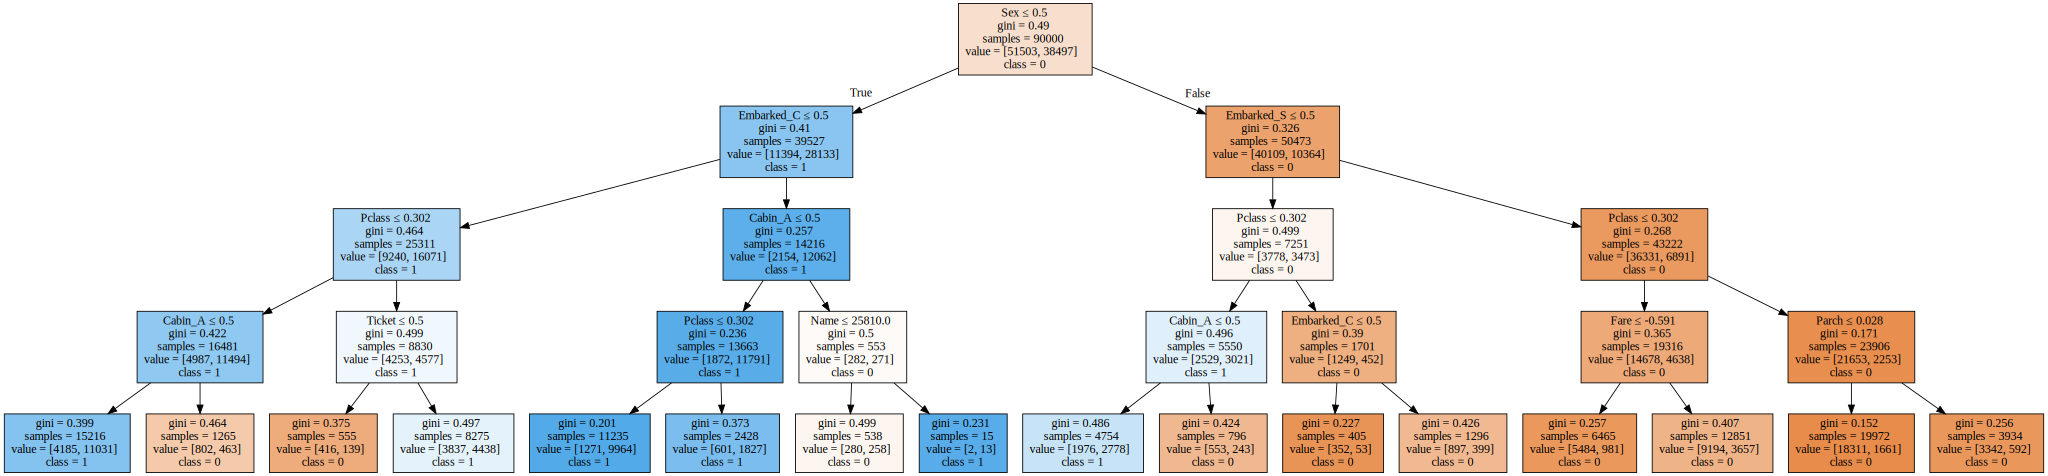

In [21]:
dot_data = export_graphviz(
    model,
    out_file = None,
    feature_names = X_train.columns,
    class_names = ['0', '1'],
    filled = True,
    rounded = False,
    special_characters = True,
    precision = 3
)
graph = graphviz.Source(dot_data)
graph

## Ensemble

In [22]:
submission_df['submit_lgb'] = [1 if pred >= 0.5 else 0 for pred in lgb_preds]
submission_df['submit_ctb'] = [1 if pred >= 0.5 else 0 for pred in ctb_preds]
submission_df['submit_dtm'] = [1 if pred >= 0.5 else 0 for pred in dtm_preds]

In [23]:
submission_df

,PassengerId,Survived,submit_lgb,submit_ctb,submit_dtm
0,100000,1,0,0,0
1,100001,1,1,1,1
2,100002,1,1,1,1
3,100003,1,0,0,0
4,100004,1,1,1,1
...,...,...,...,...,...
99995,199995,1,1,1,1
99996,199996,1,0,0,0
99997,199997,1,0,0,0
99998,199998,1,1,1,1


In [24]:
# 세 모델의 행 별로 생존자의 수를 더함
# 0은 모두 사망으로 예측, 1은 하나만, 2는 두 모델, 3은 세 모델이 모두 생존으로 예측
submission_df[[col for col in submission_df.columns if col.startswith('submit_')]]\
.sum(axis=1).value_counts()

0    63520
3    29333
1     4757
2     2390
dtype: int64

In [25]:
# 합이 2보다 크면 True -> int로 변환 (1)
submission_df[TARGET] = (submission_df[[col for col in submission_df.columns\
                                  if col.startswith('submit_')]].sum(axis=1) >= 2)\
                                  .astype(int)

In [26]:
submission_df.drop([col for col in submission_df.columns if col.startswith('submit_')],\
                 axis=1, inplace=True)

In [27]:
submission_df.to_csv('Apr_Ensemble.csv', index=False)

score: 0.80305, 369등